# Import the libraries

In [14]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
# from brian2 import TimedArray
#Libraries for ANN
import os
import sys
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
import torchvision
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d,Conv1d,MaxPool1d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.autograd import Variable
import matplotlib.pyplot as plt
import scipy as sc
from scipy.signal import butter, lfilter, welch, square  #for signal filtering
import pandas as pd
import neo
from scipy.spatial import distance
from sklearn import preprocessing
import torch.optim as optim

# Load the data

In [16]:
cwd = str(os.getcwd()) #Get the current working directory
path_of_recordings = cwd + '/recordings/' #Path where all the recordings are stored
raw_labels = np.genfromtxt(os.path.join(path_of_recordings, 'filename_and_labels.txt'), dtype=np.str)#Load the file containing label corresponding to file name


X = [] #X is a list with each element a recording
Y = [] #Y is a list with each element being label of that recording

indexes = np.array((0,1, 2, 3, 5, 7,8, 10, 11, 14, 15, 16, 17,18, 19, 20, 22, 23, 24, 25, 29, 30 ))
#I have added 0 as it's time stamp

for i in range(raw_labels.shape[0]):
    file_name = raw_labels[i,0]
    label = raw_labels[i,1]
    path_of_file = os.path.join(path_of_recordings, file_name) + '.txt'
    raw_data = np.loadtxt(path_of_file)#Load the raw data
    X.append(raw_data[indexes,1500:25500])#Append the loaded array to the list. Note that we just take selected indexes
    #[300:2400] : Because we trim 50ms from start and end
    Y.append(int(label))#Append the label

In [17]:
raw_labels

array([['0Trial_210712_103938', '0'],
       ['100Trial_210712_114923', '1'],
       ['101Trial_210712_115031', '1'],
       ['102Trial_210712_115139', '1'],
       ['103Trial_210712_115238', '1'],
       ['104Trial_210712_115339', '1'],
       ['105Trial_210712_151901', '1'],
       ['106Trial_210712_152020', '1'],
       ['107Trial_210712_152203', '1'],
       ['108Trial_210712_152340', '1'],
       ['109Trial_210712_152501', '1'],
       ['110Trial_210712_152610', '1'],
       ['112Trial_210712_152815', '1'],
       ['113Trial_210712_152910', '1'],
       ['114Trial_210712_153007', '1'],
       ['115Trial_210712_153059', '1'],
       ['116Trial_210712_153154', '1'],
       ['117Trial_210712_153315', '1'],
       ['118Trial_210712_153429', '1'],
       ['119TRial_210712_153538', '1'],
       ['120Trial_210712_153658', '1'],
       ['121Trial_210712_154136', '1'],
       ['122Trial_210712_154259', '1'],
       ['123Trial_210712_154449', '1'],
       ['124Trial_210712_154824', '1'],
  

# Plot a sample segment

(24000,)
(21, 24000)


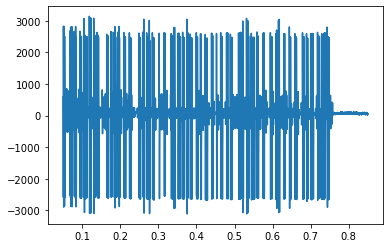

In [18]:
sample_data = X[0]#Load the first element of list
time_stamp = sample_data[0,:]#Slice off the time stamps
data = sample_data[1:,:]#Slice the data
print(time_stamp.shape)
print(data.shape)
sample_segment = data[1,:]
plt.plot(time_stamp, sample_segment)

# Split the data into train and test 

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    stratify=Y, 
                                                    test_size=0.33)
#We use stratification to preserve class balance in train and test

# Slice the data in segments of 200ms.
### We now also drop the time stamp as that's not useful for classification

In [20]:
X_train_segmented = []
Y_train_segmented = []
X_train_segmented_avereged = []
X_train_segmented_3D = []


for i in range(len(Y_train)):
    data = X_train[i]
    data = data[1:,:]#Drop the time stamps
    #24000 time points corresponds to 800 ms. Hence, 6000 time points corresponds to 200 ms
    for j in range(4):
        #The 2D X_train_segmented is flatten to 1D. Final shape being (1,nbChannel*nbTimepoints)
        X_train_segmented.append(data[:,j*6000:(j+1)*6000].flatten())
        
        #The 2D X_train_segmented is avereged along time axis. Final shape being (1,nbChannel)
        X_train_segmented_avereged.append(np.mean(data[:,j*6000:(j+1)*6000], axis =1))
        Y_train_segmented.append(Y_train[i])
        #X_train_segmented_3D is the 3D version of form (1, nbChannels, nbTimepoints)
        X_train_segmented_3D.append(data[:,j*6000:(j+1)*6000])
        
X_test_segmented = []
Y_test_segmented = []
X_test_segmented_avereged = []
X_test_segmented_3D = []

for i in range(len(Y_test)):
    data = X_test[i]
    data = data[1:,:]#Drop the time stamps
    #24000 time points corresponds to 800 ms. Hence, 6000 time points corresponds to 200 ms
    for j in range(4):
        X_test_segmented.append(data[:,j*6000:(j+1)*6000].flatten())
        X_test_segmented_avereged.append(np.mean(data[:,j*6000:(j+1)*6000], axis =1))
        Y_test_segmented.append(Y_test[i])
        X_test_segmented_3D.append(data[:,j*6000:(j+1)*6000])

#Save the data for future use
cwd = str(os.getcwd())
file_directory =cwd + '/recordings/'
filename = '/EMG_dataset_OCET.npz'
file_path = file_directory+filename
np.savez_compressed(file_path, 
                    X_train_segmented=X_train_segmented,
                    Y_train_segmented=Y_train_segmented,
                    X_train_segmented_avereged=X_train_segmented_avereged,
                    X_test_segmented = X_test_segmented,
                    Y_test_segmented = Y_test_segmented,
                    X_test_segmented_avereged=X_test_segmented_avereged,
                    X_train_segmented_3D=X_train_segmented_3D,
                    X_test_segmented_3D=X_test_segmented_3D
                   )


# Fit a classifier and evaluate performance

## Fit with entire data of dimension (1,nbChannel*nbTimepoints)

In [21]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train_segmented, Y_train_segmented)

#Predict the response for test dataset
Y_pred = clf.predict(X_test_segmented)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test_segmented, Y_pred))

Accuracy: 0.48148148148148145


In [78]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=12, n_estimators=100,random_state=0,max_features='sqrt')

#Train the model using the training sets
clf.fit(X_train_segmented, Y_train_segmented)

#Predict the response for test dataset
Y_pred = clf.predict(X_test_segmented)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test_segmented, Y_pred))

from pprint import pprint# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(clf.get_params())

Accuracy: 0.48148148148148145
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


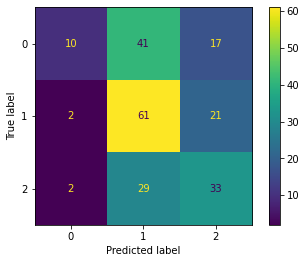

In [22]:
plot_confusion_matrix(clf, X_test_segmented, Y_test_segmented)

## Fit with data avereged along time axis of dimension (1,nbChannel)

In [28]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf',gamma='scale') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train_segmented_avereged, Y_train_segmented)

#Predict the response for test dataset
Y_pred = clf.predict(X_test_segmented_avereged)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test_segmented, Y_pred))

Accuracy: 0.5231481481481481


In [75]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=12, n_estimators=100,random_state=0,max_features='sqrt')

#Train the model using the training sets
clf.fit(X_train_segmented_avereged, Y_train_segmented)

#Predict the response for test dataset
Y_pred = clf.predict(X_test_segmented_avereged)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test_segmented, Y_pred))

from pprint import pprint# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(clf.get_params())

Accuracy: 0.6435185185185185
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


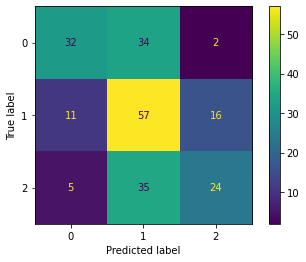

In [24]:
plot_confusion_matrix(clf, X_test_segmented_avereged, Y_test_segmented)

In [74]:
# from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]# Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)

In [27]:
len(Y_train_segmented)

428

# Fit a multi level perceptron based neural network (Non-spiking)

In [173]:
# from keras.layers import Conv1D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D
# from keras.models import Model#this base model is one branch of the main model
# #it takes a time series as an input, performs 1-D convolution, and returns it as an output ready for concatenationdef get_base_model(input_len, fsize):
# #the input is a time series of length n and width 19
# input_seq = Input(shape=(input_len, 19))
# #choose the number of convolution filters
# nb_filters = 10
# #1-D convolution and global max-pooling
# convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
# processed = GlobalMaxPooling1D()(convolved)
# #dense layer with dropout regularization
# compressed = Dense(50, activation="tanh")(processed)
# compressed = Dropout(0.3)(compressed)
# model = Model(inputs=input_seq, outputs=compressed)
# return model#this is the main model
# #it takes the original time series and its down-sampled versions as an input, and returns the result of classification as an outputdef main_model(inputs_lens = [512, 1024, 3480], fsizes = [8,16,24]):
# #the inputs to the branches are the original time series, and its down-sampled versions
# input_smallseq = Input(shape=(inputs_lens[0], 19))
# input_medseq = Input(shape=(inputs_lens[1] , 19))
# input_origseq = Input(shape=(inputs_lens[2], 19))#the more down-sampled the time series, the shorter the corresponding filter
# base_net_small = get_base_model(inputs_lens[0], fsizes[0])
# base_net_med = get_base_model(inputs_lens[1], fsizes[1])
# base_net_original = get_base_model(inputs_lens[2], fsizes[2])embedding_small = base_net_small(input_smallseq)
# embedding_med = base_net_med(input_medseq)
# embedding_original = base_net_original(input_origseq)#concatenate all the outputs
# merged = Concatenate()([embedding_small, embedding_med, embedding_original])
# out = Dense(1, activation='sigmoid')(merged)model = Model(inputs=[input_smallseq, input_medseq, input_origseq], outputs=out)
# return model

# TODO: https://www.kaggle.com/purplejester/pytorch-deep-time-series-classification

# TODO: https://medium.com/@aungkyawmyint_26195/multi-layer-perceptron-mnist-pytorch-463f795b897a

## Create a pytorch data loader

In [168]:
device = 'cpu'
cwd = str(os.getcwd())
file_directory =cwd + '/recordings/'
filename = '/EMG_dataset_OCET.npz'
file_path = file_directory+filename

class EMGDataset(Dataset):
    
    def __init__(self, file_path, train=True):    
        data=np.load(file_path,allow_pickle=True )
        X_EMG_Train = data['X_train_segmented_3D']
        Y_EMG_Train = data['Y_train_segmented']
        X_EMG_Test = data['X_test_segmented_3D']
        Y_EMG_Test = data['Y_test_segmented']
        if(train):                     
            self.n_samples = Y_EMG_Train.shape[0]
            self.features = torch.from_numpy(X_EMG_Train).float()
            self.labels = torch.from_numpy(Y_EMG_Train).float()
        else :
            self.n_samples = Y_EMG_Test.shape[0]
            self.features = torch.from_numpy((X_EMG_Test)) # size [n_samples, n_features]
            self.labels = torch.from_numpy(Y_EMG_Test) # size [n_samples, 1]
    def __getitem__(self, index):
        if self.labels[index] == 0:
            label = 0
        elif self.labels[index] == 1:
            label = 1
        elif self.labels[index] == 2:
            label = 2
        return np.transpose(np.asarray(self.features[index, :]).astype(np.float)), label

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

dataset_train = EMGDataset(train=True, file_path=file_path)
dataset_test = EMGDataset(train=False, file_path=file_path)

train_loader = DataLoader(dataset=dataset_train,
                          batch_size=1,
                          shuffle=True,
                          num_workers=0)
test_loader = DataLoader(dataset=dataset_test,
                          batch_size=1,
                          shuffle=False,
                          num_workers=0)

## Define and test a 1D CNN

In [176]:
# '''
# Not working at the moment
# '''
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.autograd import Variable


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
        
#     model = Sequential()
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6000,21)))
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Flatten())
#     model.add(Dense(100, activation='relu'))
#     model.add(Dense(3, activation='softmax'))

    

#     def forward(self, input):
#         x = self.cnn_layers(input)
#         x = x.view(x.size(0), -1)
#         x = self.linear_layers(x)
#         return x
    
    
# def test(model, test_loader):
#     correct = 0
#     for batch_idx, (data, target) in enumerate(test_loader):
#         data = data.float()
#         output = model(data.to(device))
#         pred = output.data.max(1)[1]
#         correct += pred.eq(target.to(device).data.view_as(pred)).cpu().sum()

#     return 100. * float(correct) / float(len(test_loader.dataset))

# # device = torch.device('cpu' if 'cpu' in memtorch.__version__ else 'cuda')
# device = 'cpu'
# epochs = 100
# model = Net().to(device)
# criterion = nn.CrossEntropyLoss()
# learning_rate = 1e-2
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# best_accuracy = 0
# for epoch in range(0, epochs):
#     print('Epoch: [%d]\t\t' % (epoch + 1), end='')
#     if epoch % 10 == 0:
#         learning_rate = learning_rate * 0.5
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = learning_rate

#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         optimizer.zero_grad()
#         data = data.float()
#         output = model(data.to(device))
#         loss = criterion(output, target.to(device))
#         loss.backward()
#         optimizer.step()

#     accuracy = test(model, test_loader)
#     print('%2.2f%%' % accuracy)
#     if accuracy > best_accuracy:
#         torch.save(model.state_dict(), 'trained_model.pt')
#         best_accuracy = accuracy

# Train a SNN (Perceptron & MLP)
### With brian2. 
### from brian2 import TimedArray

Feed from nbChannels to a layer of neurons of size (~nBchannels*5). Readout the activity through a softmax layer of perceptrons or SVM/LDA

In [ ]:
# 

# Train an MLP (non-spiking with backprop)